## MONFORT Baptiste - REYNOSO VALDES Ana Karen - DURAND Valentine
# CHALLENGE ENS : Learning factors for stock market returns prediction

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.linear_model import LinearRegression

## Data preprocessing

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Challenge S3')

In [30]:
path = '../'

X_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge S3/X_train.csv', index_col=0, sep=',')
X_train_df.columns.name = 'date'

Y_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge S3/Y_train.csv', index_col=0, sep=',')
Y_train_df.columns.name = 'date'

In [31]:
# Subset Y_train_df to keep only the columns present in X_train_df
Y_train_df = X_train_df.iloc[:, :250].copy()

# Display the result
print(Y_train_df)


date             0         1         2         3         4         5  \
stocksID                                                               
0        -0.018647 -0.013002 -0.010776 -0.016676 -0.005110  0.009092   
1        -0.008254 -0.022280  0.012173 -0.006820 -0.004055  0.012912   
2        -0.008404 -0.013629 -0.006044 -0.003425 -0.009522 -0.001353   
3        -0.022734 -0.006981 -0.008568 -0.010899 -0.017981  0.002485   
4        -0.024546 -0.008315 -0.007991 -0.003515  0.007872  0.007082   
5        -0.019243 -0.004789 -0.004691  0.002805 -0.006069  0.013317   
6         0.000083 -0.006233 -0.009110  0.054403 -0.012260 -0.007213   
7        -0.015313 -0.014736 -0.000887 -0.007216 -0.002479  0.009570   
8        -0.001305 -0.004197 -0.019816 -0.005595  0.008634 -0.008648   
9        -0.020038 -0.012818 -0.013035 -0.006182 -0.022030 -0.003747   
10       -0.001147 -0.016695  0.007454 -0.005303  0.003181  0.016117   
11       -0.002341 -0.002456  0.011379  0.004098 -0.008227  0.01

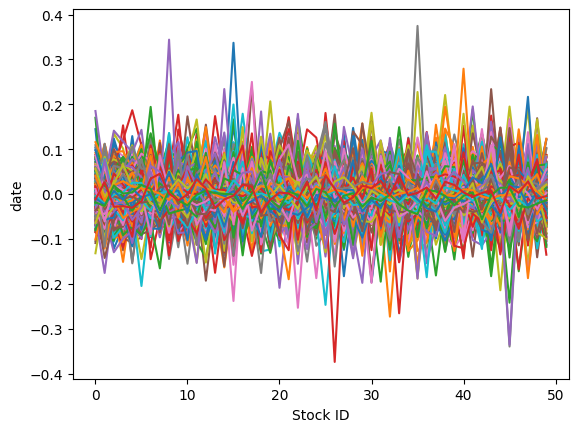

In [32]:
from sklearn import preprocessing
#Normalize X
X_norm = preprocessing.normalize(X_train_df)
# Plot the normalized dataset
plt.plot(X_norm)
plt.xlabel('Stock ID')
plt.ylabel('date')
plt.show()

Normalize the returns by subtracting the mean and dividing by the standard deviation to ensure that all the stocks are on the same scale.

In [33]:
# Normalize the returns by subtracting the mean and dividing by the standard deviation
X_train_norm = (X_train_df - np.mean(X_train_df, axis=1).values.reshape(-1, 1)) / np.std(X_train_df, axis=1).values.reshape(-1, 1)

# Factor Matrix

In [34]:
from scipy.stats import skew

train_data = X_train_norm
train_data = train_data.dropna(axis=1)
train_data = train_data.iloc[:,1:]


# Define the factors: momentum, mean returns, and volatility
momentum = np.zeros(train_data.shape[1])
mean_returns = np.mean(train_data, axis=0)  # 5-day mean returns
volatility = train_data.rolling(window=50).std()  # 50-day rolling standard deviation
#skewness = skew(train_data, axis=0)  # skewness of returns for each stock

for i in range(1, train_data.shape[1]):
    momentum[i] = np.dot(train_data.iloc[:, i-1], train_data.iloc[:, i])

# Reshape mean_returns, momentum, and volatility
mean_returns = np.repeat(mean_returns[:, np.newaxis], volatility.shape[0], axis=1).T
momentum = np.repeat(momentum[:, np.newaxis], volatility.shape[0], axis=1).T

# Stack the factors into a matrix
factor_matrix = np.stack([mean_returns, momentum, volatility], axis=2)


<ipython-input-34-6d7089cb092c>:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mean_returns = np.repeat(mean_returns[:, np.newaxis], volatility.shape[0], axis=1).T


### Independence Condition

In [35]:
# Orthogonalize the factor matrix using the Gram-Schmidt process
def gram_schmidt(A):
    Q, R = np.linalg.qr(A)
    return Q

factor_matrix_ortho = gram_schmidt(factor_matrix)


## Learn the model parameters

In [36]:
def ortho(X):
    Q, R = np.linalg.qr(X)
    return Q

To create 10 factors fir factor matrix

In [37]:
# Create factor matrix
factor_matrix = np.concatenate([np.mean(X_train_df.values[:,i:i+5], axis=1, keepdims=True) for i in range(0, X_train_df.shape[1]-4)], axis=1)
factor_matrix_norm = factor_matrix / np.linalg.norm(factor_matrix, axis=0)  # normalize factors

# Keep the top 10 factors based on the largest singular values
U, S, V = np.linalg.svd(factor_matrix_norm)
factor_matrix_ortho = U[:, :10]

# Learn the model parameters using linear regression
model = LinearRegression().fit(factor_matrix_ortho, Y_train_df)
beta = model.coef_  # learned beta parameters
A = np.linalg.inv(factor_matrix_ortho.T.dot(factor_matrix_ortho)).dot(factor_matrix_ortho.T).dot(Y_train_df)  # learned A parameters
A = A.reshape(-1, beta.shape[1])  # reshape A to have the same number of columns as beta

 **Gram-Schmidt process**, which is a method for orthonormalizing a set of vectors

In [38]:
Q, R = np.linalg.qr(A)  # QR decomposition of A
A_ortho = Q  # orthonormalize Q

# Verify that A_ortho is orthonormal
assert np.allclose(np.eye(A_ortho.shape[1]), A_ortho.T.dot(A_ortho))

In [39]:
A_ortho.shape

(250, 10)

In [40]:
factor_matrix_ortho

array([[-2.69625284e-01,  1.29663861e-01, -1.73571212e-02,
         1.46727219e-01, -7.64262691e-02,  5.16037961e-02,
        -2.09994392e-03,  2.18567071e-02, -5.85785263e-02,
         1.92515370e-02],
       [-1.09426990e-01, -2.33459568e-02, -9.65198452e-03,
        -1.68102291e-01, -9.07019262e-04, -3.27966741e-02,
         1.75413988e-03,  5.76621499e-02, -3.40061396e-02,
        -7.43808918e-02],
       [-1.92163018e-01,  1.45640053e-01, -3.92762786e-02,
         1.23561982e-01, -3.72195870e-02, -1.49855899e-05,
         1.78480456e-02, -5.59375772e-02, -9.41073030e-02,
        -3.86427781e-03],
       [-2.69859956e-01,  1.37588547e-01, -2.53407563e-02,
         1.60204970e-01, -4.50318385e-02,  6.12808329e-02,
         2.81870675e-02,  1.84292996e-02, -3.10066957e-02,
        -8.65667388e-03],
       [-2.17061491e-01,  1.80671939e-01,  2.05315219e-02,
         3.11782397e-02, -4.77301093e-02, -5.56039463e-02,
         2.94709136e-02,  1.22190150e-02, -3.11905053e-02,
        -2.

The interpretation of these factors is not immediately obvious, as they are not directly related to any individual feature in the original data. However, they capture the most important patterns and correlations in the data, which can be used to make accurate predictions of future returns.

To gain a better understanding of the specific patterns and correlations captured by these factors, further analysis and visualization of the data and the factors may be necessary.

In [41]:
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    if any(Error.unstack() > 1e-6):
        bool = False
     
    return bool

In [42]:
#Check if A is Orthonomal
checkOrthonormality(A_ortho)

True

### Reshape X train

In [43]:
X_train_reshape = pd.concat([X_train_df.T.shift(i+1).stack(dropna=False) for i in range(250) ], 1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag')

<ipython-input-43-e579aa6823ff>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  X_train_reshape = pd.concat([X_train_df.T.shift(i+1).stack(dropna=False) for i in range(250) ], 1).dropna()


## Functions

In [44]:
def fitBeta(A):
    
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y_train_df.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    
    return beta.to_numpy()

In [45]:
def metric_train(A_ortho, beta):
    if not checkOrthonormality(A_ortho):
        return -1.0
    A_ortho_norm = A_ortho / np.linalg.norm(A_ortho, axis=0)  # normalize columns
    A_ortho_beta = np.concatenate([A_ortho_norm, beta], axis=1)  # transpose A_ortho_norm instead of beta
    A_ortho_beta_norm = A_ortho_beta / np.linalg.norm(A_ortho_beta, axis=0)  # normalize columns
    corr = np.abs(np.corrcoef(A_ortho_beta_norm.T))
    return (np.sum(corr) - np.trace(corr)) / 250
print("A_ortho :", A_ortho.shape)
print("beta :", beta.shape)

metric_train_benchmark = 0.0342
our_metric_train = metric_train(A_ortho, beta)
difference = metric_train_benchmark-our_metric_train

if(metric_train_benchmark > our_metric_train):
    print("Our metric train : ", our_metric_train, "is less than the benchmark :", metric_train_benchmark, "by a difference of", difference)
else:
    print("Our metric train : ", our_metric_train, "is better than the benchmark :", metric_train_benchmark, "by a difference of", -difference)

A_ortho : (250, 10)
beta : (250, 10)
Our metric train :  0.05886686291976435 is better than the benchmark : 0.0342 by a difference of 0.024666862919764346


## Test the predictive model

In order to thiswe must divide create a X_test set

In [46]:
from sklearn.model_selection import train_test_split
#Split data into train set and test set to evaluate the performances of the model.
X = X_train_df[X_train_df.columns[:]]
y = Y_train_df[Y_train_df.columns[:]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Normalize the returns
X_train_mean = np.mean(X_train.to_numpy(), axis=0, keepdims=True)
X_train_std = np.std(X_train.to_numpy(), axis=0, keepdims=True)
X_test_norm = (X_test.to_numpy() - X_train_mean) / X_train_std


In [48]:
# Calculate the factor matrix
mean_returns_test = np.mean(X_test_norm, axis=0)  # 5-day mean returns
momentum_test = np.zeros(X_test_norm.shape[1])
for i in range(1, X_test_norm.shape[1]):
    momentum_test[i] = np.dot(X_test_norm[:, i-1], X_test_norm[:, i])

factor_matrix_test = np.stack([mean_returns_test, momentum_test], axis=1)


In [50]:

def predict(X, A_ortho, beta):
    # Reshape input data into a matrix of shape (num_samples, num_features*num_time_lags)
    X_reshape = pd.concat([X_test.T.shift(i+1).stack(dropna=False) for i in range(250)], axis=1).dropna()
    X_reshape.columns = pd.Index(range(1, 251), name='timeLag')

    # Calculate the factors
    factor_matrix = np.concatenate([np.mean(X_reshape.values[:, i:i+5], axis=1, keepdims=True) for i in range(0, X_reshape.shape[1]-4)], axis=1)
    factor_matrix_norm = factor_matrix / np.linalg.norm(factor_matrix, axis=0)
    factor_matrix_norm = (factor_matrix_norm.T)
    
    #factor_matrix_norm = factor_matrix_norm[:, :504]
    #factor_matrix_ortho = factor_matrix_norm.dot(A_ortho)
    
    # Predict the returns using the learned beta parameters and the factor matrix
    Y_pred = factor_matrix_ortho.dot(beta.T)
    return Y_pred

In [51]:
print("y_test", y_test.shape)

y_test (10, 250)


In [52]:
from sklearn.metrics import r2_score
# Evaluate the performance of the model on the test set
Y_test_pred = predict(X_test, A_ortho, beta)
print("Y_test_pred :", Y_test_pred)
print("Y_test_pred.shape :", Y_test_pred.shape)
print("Y_train_df.shape :", Y_train_df.shape)
#Y_test_pred // Y_train_df

Y_test_pred : [[-2.42044244e-02 -6.31088307e-03  5.74899012e-05 ...  6.94856596e-03
   1.45490720e-03  8.91378361e-03]
 [-1.07809300e-02 -1.20218382e-02  6.43765727e-03 ... -3.34589190e-03
   1.20187223e-03 -6.12398240e-04]
 [-1.65191485e-02 -2.45175862e-03 -7.79614095e-04 ...  6.83554656e-03
   3.92019470e-04  6.03579146e-03]
 ...
 [-6.78496178e-03 -3.78117064e-03 -2.81277403e-03 ... -3.29858159e-04
   1.84340530e-03 -6.33320705e-04]
 [ 2.00549696e-02  2.81181144e-03  7.97403574e-04 ... -6.56516176e-03
   2.74906087e-04 -5.98604452e-04]
 [-1.14754943e-02 -1.06411145e-02  5.58219179e-03 ... -2.19371314e-03
   5.73094112e-04 -4.34861405e-04]]
Y_test_pred.shape : (50, 250)
Y_train_df.shape : (50, 250)


In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assume we have predicted values y_pred and actual values y_test
mse = mean_squared_error(Y_train_df, Y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_train_df, Y_test_pred)
r2 = r2_score(Y_train_df, Y_test_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

MSE: 6.754673852517551e-05
RMSE: 0.008218682286423749
MAE: 0.0059772900485623665
R-squared: 0.4960438858164148


Create an output file with A and beta

In [59]:
def parametersTransform(A, beta, D=250, F=10):
    
    if A.shape != (D, F):
        print('A has not the good shape')
        return
    
    if beta.shape[0] != F:
        return        
    
    output = np.hstack( (np.hstack([A.T, beta.reshape((F, 1))])).T )
    
    return output

In [60]:
# from output to csv file...
output = parametersTransform(A_ortho, beta)
pd.DataFrame(output).to_csv(path + 'submission.csv')

# ... and back
output_fromCsv = pd.read_csv(path + 'submission.csv', index_col=0, sep=',').to_numpy()

print("A_ortho.shape :", A_ortho.shape)
print("beta.shape :", beta.shape)
print("beta.shape[0] :", beta.shape[0])

#A_ortho = output_fromCsv[:-10].reshape((250, 10))
#beta = output_fromCsv[-10:].reshape((10))

combined_arr = np.concatenate([A_ortho.reshape((250, 10))
                               , beta[0].reshape((1,10))], axis=0)

# Save the combined array into a csv file
np.savetxt('output.csv', combined_arr, delimiter=',')

A_ortho.shape : (250, 10)
beta.shape : (250, 10)
beta.shape[0] : 250
